In [1]:
import os
import math
import wandb
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
linewidth = 5.52062486111

sns.set_style("whitegrid", {
    'grid.linestyle': '--', 'xtick.bottom': True, 'ytick.left': True, 'axes.edgecolor': '.15',
})

plt.rc('font', size=9)
plt.rc('font', family="Times New Roman")
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.titleweight'] = 'normal'
plt.rcParams['axes.linewidth'] = .5
plt.rcParams['font.stretch'] = 'condensed'
plt.rc('font', serif="Times")
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('axes', titlesize='medium')
plt.rc('axes', labelsize='small')
plt.rc('legend',fontsize='small')
plt.rcParams['xtick.major.pad'] = '2'
plt.rcParams['ytick.major.pad'] = '2'
plt.rcParams['xtick.major.width'] = .5
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.width'] = .5
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['axes.titlepad'] = 2
plt.rcParams['figure.dpi'] = 200
plt.rcParams['text.color'] = '.0'
plt.rcParams['xtick.color'] = '.0'
plt.rcParams['ytick.color'] = '.0'
plt.rcParams['axes.labelcolor'] = '.0'

save_dir = "/private/home/linamezghani/papers/offline-gcrl/62a0af5647c916f651ac175b/fig"

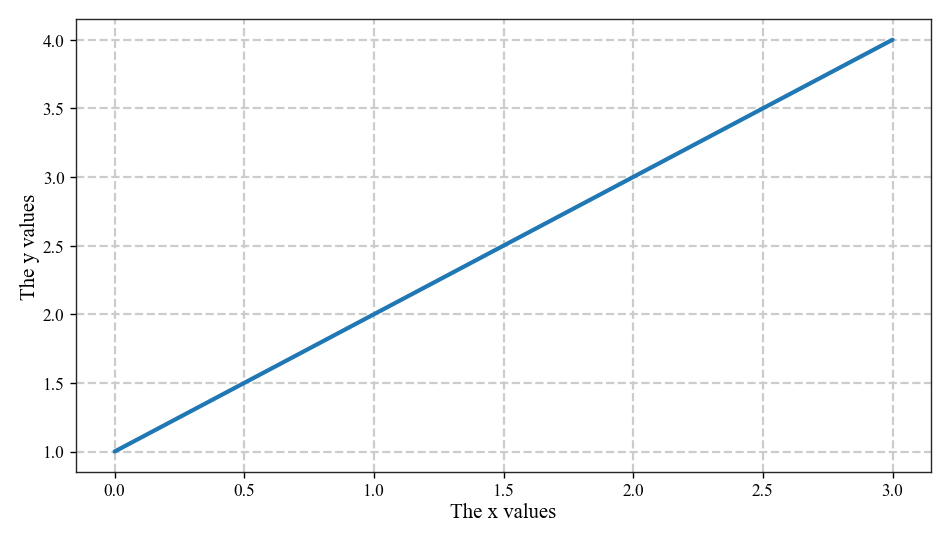

In [3]:
fig = plt.figure(figsize=(linewidth, 3))
ax = fig.add_subplot(1, 1, 1)
plt.plot([1, 2, 3, 4])
ax.set_xlabel('The x values')
ax.set_ylabel('The y values')

plt.savefig(os.path.join(save_dir, "remotely_fig.pdf"))

In [4]:
api = wandb.Api()

runs = {env: api.runs(f"linamezghani/offline_gcrl_{env}") for env in ["walker", "maze_U4rooms"]}
run_ids = {env: {run.name: run.id for run in runs[env]} for env in ["walker", "maze_U4rooms"]}

def add_all_seeds(exp_name):
    return [exp_name, exp_name.replace('s123', 's234'), exp_name.replace('s123', 's345')]

In [5]:
def create_df(exp_dict, metrics, env, num_samples=10000, window_size=10, smoothing=False):
    df = pd.DataFrame()
    for exp_id, exp_names in exp_dict.items():
        for exp_name in exp_names:
            temp_df = pd.DataFrame(columns=metrics + ["step"])
            run = api.run(f"linamezghani/offline_gcrl_{env}/{run_ids[env][exp_name]}")
            for i, row in run.history(samples=num_samples).iterrows():
                for metric in metrics:
                    if not math.isnan(row[metric]):
                        temp_df.at[int(row["_step"]), "step"] = int(row["_step"])
                        temp_df.at[int(row["_step"]), metric] = row[metric]
            if smoothing:
                for metric in metrics:
                    temp_df[metric] = temp_df[metric].rolling(window_size, min_periods=1).mean()
            temp_df['exp_id'] = exp_id
            temp_df['exp_name'] = exp_name
            df = df.append(temp_df, ignore_index=True)
    return df

## Actionable Models Comparison - Maze

In [105]:
env = "maze_U4rooms"

metrics = [
    "eval/oracle_success",
    "eval/oracle_success-room1",
    "eval/oracle_success-room2",
    "eval/oracle_success-room3",
    "eval/oracle_success-room4"
]

exp_dict = {
    "Ours": "20220613-100554_maze_U4rooms_rs0.1-lr0.0003-bs2048-updates1000-alpha0.05-gamma0.9-graph_sig-reward-temp-1-subgoalTrue-asym-fix-seed_cudnn_s123_r0",
    "HER": "20220613-082352_maze_U4rooms_baseline-HER-final-neg-action-None-neg-goal-zero_s123_r0",
    "HER + random negative action": "20220613-082744_maze_U4rooms_baseline-HERu-final-neg-action-uniform-neg-goal-zero_s123_r0",
    "Actionable Models": "20220613-081755_maze_U4rooms_baseline-AM-final-neg-action-policy-neg-goal-critic_s123_r0",
}

for k, v in exp_dict.items():
    exp_dict[k] = add_all_seeds(v)

df = create_df(exp_dict, metrics, env, smoothing=True)
df = df[df["step"] < 1001]

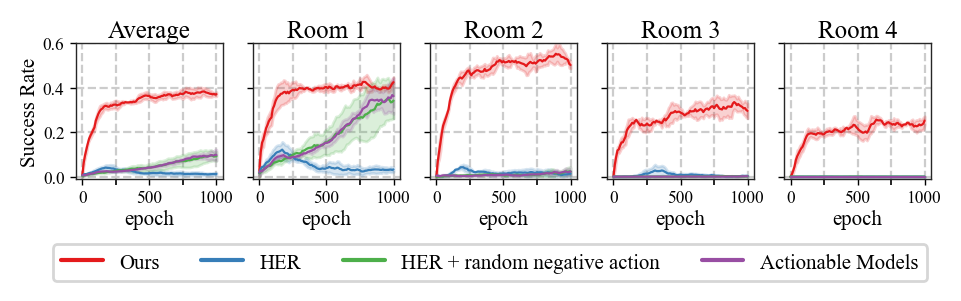

In [142]:
fig, axes = plt.subplots(1, 5, figsize=(linewidth, .9))
lines = []

major_xticks = [0, 500, 1000]
minor_xticks = [250, 750]

lineplot_kwargs = dict(
    x="step", ci="sd", data=df, hue="exp_id", legend=False, linewidth=0.8, label='dummy', palette='Set1'
)

set_kwargs = dict(xlabel='epoch', ylim=(-0.01, .6), yticks=[0, 0.2, 0.4, 0.6])

sns.lineplot(
    y="eval/oracle_success", ax=axes[0], **lineplot_kwargs
).set(
    ylabel='Success Rate', title='Average', **set_kwargs
)
axes[0].set_xticks(major_xticks)
axes[0].set_xticks(minor_xticks, minor=True)
axes[0].grid(which='minor')

for i in range(1, 5):
    sns.lineplot(
        y=f"eval/oracle_success-room{i}", ax=axes[i], **lineplot_kwargs
    ).set(
        ylabel=None, title=f'Room {i}', **set_kwargs
    )
    axes[i].tick_params(labelleft=False)
    axes[i].set_xticks(major_xticks)
    axes[i].set_xticks(minor_xticks, minor=True)
    axes[i].grid(which='minor')

lines, labels = axes[-1].get_legend_handles_labels()
labels = list(exp_dict.keys())
leg = fig.legend(
    lines, labels, ncol=4, loc="lower center",  bbox_to_anchor = (0,-0.5,1,1), bbox_transform = plt.gcf().transFigure,
    markerscale=0.01
)


for legobj in leg.legendHandles:
    legobj.set_linewidth(1.5)

plt.show()

fig.savefig(os.path.join(save_dir, "maze_perf.pdf"), bbox_inches='tight')


## RNet rewards vs. Graph Rewards - Maze

In [143]:
metrics = [
    "eval/oracle_success",
    "eval/oracle_success-room1",
    "eval/oracle_success-room2",
    "eval/oracle_success-room3",
    "eval/oracle_success-room4"
]

nice_names = ["Avg", "Room1", "Room2", "Room3", "Room4"]

rename_dict = {metrics[i]: nice_names[i] for i in range(len(metrics))}

exp_dict = {
    "Graph Reward": "20220613-100554_maze_U4rooms_rs0.1-lr0.0003-bs2048-updates1000-alpha0.05-gamma0.9-graph_sig-reward-temp-1-subgoalTrue-asym-fix-seed_cudnn_s123_r0",
    "RNet Reward": "20220614-110702_maze_U4rooms_rnet-rewards-rs0.1_s123_r0",
}

for k, v in exp_dict.items():
    exp_dict[k] = add_all_seeds(v)

df = create_df(exp_dict, metrics, env="maze_U4rooms")
df = df[df["step"] < 1001]
df = df[df["step"] > 900]
df = df.rename(columns=rename_dict)

In [144]:
new_df = df.melt(
    var_name = 'metric', value_vars=nice_names, id_vars=["exp_id"], value_name="Success Rate"
)

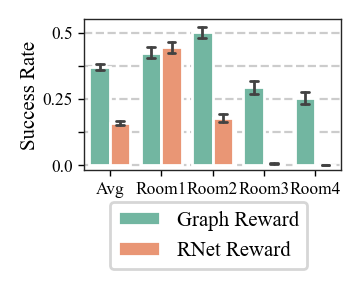

In [145]:
fig = plt.figure(figsize=(.3 * linewidth, 1))
sns.barplot(
    x="metric", y="Success Rate", data=new_df, hue="exp_id", capsize=.15, errwidth=1., palette='Set2'
).set(
    xlabel=None, ylim=(-0.02, 0.55), yticks=[0, 0.25, 0.5]
)
plt.yticks([0, 0.125, 0.25, 0.375, 0.5], [0., None, 0.25, None, 0.5])
plt.gca().legend().set_title('')
plt.gca().legend(loc="lower center", bbox_to_anchor = (0,-0.42,1,1), bbox_transform = plt.gcf().transFigure)
plt.show()

fig.savefig(os.path.join(save_dir, "graph_vs_rnet_rewards.pdf"), bbox_inches='tight')

## Actionable Models Comparison - Walker

In [154]:
env = 'walker'

metrics = [
    "eval/oracle_success",
]

exp_dict = {
    "Ours": "20220613-074149_walker_unsup-final-vec_edge-transTrue-subgoal-transTrue-with-velo_rb1M_s123_r0",
    "HER": "20220613-093751_walker_baseline-AMHER-final-neg-action-None-neg-goal-zero_s123_r0",
    "HER + random neg action": "20220613-093751_walker_baseline-AMHER-final-neg-action-uniform-neg-goal-zero_s123_r0",
    "Actionable Models": "20220613-093751_walker_baseline-AMHER-final-neg-action-policy-neg-goal-critic_s123_r0",
}

for k, v in exp_dict.items():
    exp_dict[k] = add_all_seeds(v)

df = create_df(exp_dict, metrics, env, smoothing=True)
df = df[df["step"] < 1001]

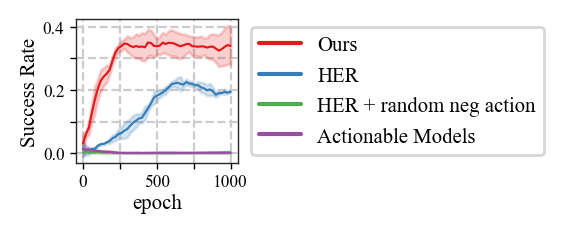

In [155]:
fig = plt.figure(figsize=(.49 * linewidth, 1.))
ax = fig.gca()

figx = 0.15
figy = 0.22
figh = 0.72
figw = 0.3

sns.lineplot(
    x="step", y="eval/oracle_success", ci="sd", data=df, hue="exp_id",  linewidth=0.8, palette='Set1'
).set(ylabel='Success Rate', xlabel='epoch')
plt.xticks([0, 250, 500, 750, 1000], labels=[0, None, 500, None, 1000])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4], [0., None, 0.2, None, 0.4])



plt.gca().legend().set_title('')
plt.gca().legend(loc="center right", bbox_to_anchor = (2.95, 0.5))
ax.set_position([figx, figy, figw, figh])

plt.show()

fig.savefig(os.path.join(save_dir, "walker_perf.pdf"), bbox_inches='tight')

## Transition Augmentations - Walker

In [159]:
metrics = [
    "eval/oracle_success",
]

exp_dict = {
    "Subgoal + Edge": "20220613-074149_walker_unsup-final-vec_edge-transTrue-subgoal-transTrue-with-velo_rb1M_s123_r0",
    "Subgoal Only": "20220613-074149_walker_unsup-final-vec_edge-transFalse-subgoal-transTrue-with-velo_rb1M_s123_r0",
    "Edge Only": "20220613-074149_walker_unsup-final-vec_edge-transTrue-subgoal-transFalse-with-velo_rb1M_s123_r0",
    "No Augmentation": "20220613-074149_walker_unsup-final-vec_edge-transFalse-subgoal-transFalse-with-velo_rb1M_s123_r0",
}

for k, v in exp_dict.items():
    exp_dict[k] = add_all_seeds(v)

df = create_df(exp_dict, metrics, env='walker', smoothing=True)
df = df[df["step"] < 1001]
df = df[df["step"] > 900]
df[''] = ''

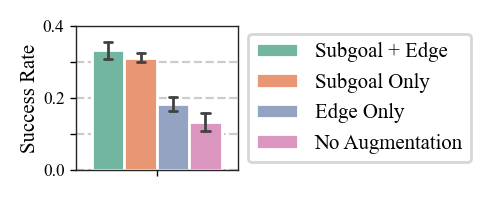

In [160]:
fig = plt.figure(figsize=(.49 * linewidth, 1.))
ax = fig.gca()

figx = 0.15
figy = 0.22
figh = 0.72
figw = 0.3

sns.barplot(
    x="", y="eval/oracle_success", data=df, hue="exp_id", capsize=.05, errwidth=1., palette='Set2'
).set(
    xlabel=None, ylabel="Success Rate"
)
plt.gca().legend().set_title('')
plt.gca().legend(loc="center right", bbox_to_anchor = (2.5, 0.5))
plt.yticks([0, 0.1, 0.2, 0.3, 0.4], [0., None, 0.2, None, 0.4])
ax.set_position([figx, figy, figw, figh])

plt.show()

fig.savefig(os.path.join(save_dir, "transition_augmentation.pdf"), bbox_inches='tight')

In [157]:
metrics = [
    "eval/oracle_success",
]

exp_dict = {
    "Subgoal + Edge": "20220613-074149_walker_unsup-final-vec_edge-transTrue-subgoal-transTrue-with-velo_rb1M_s123_r0",
    "Subgoal Only": "20220613-074149_walker_unsup-final-vec_edge-transFalse-subgoal-transTrue-with-velo_rb1M_s123_r0",
    "Edge Only": "20220613-074149_walker_unsup-final-vec_edge-transTrue-subgoal-transFalse-with-velo_rb1M_s123_r0",
    "No Augmentation": "20220613-074149_walker_unsup-final-vec_edge-transFalse-subgoal-transFalse-with-velo_rb1M_s123_r0",
}

for k, v in exp_dict.items():
    exp_dict[k] = add_all_seeds(v)

df = create_df(exp_dict, metrics, env='walker', smoothing=True)
df = df[df["step"] < 1001]

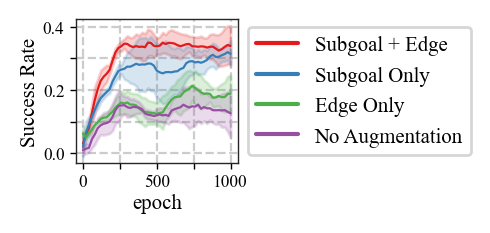

In [158]:
fig = plt.figure(figsize=(.49 * linewidth, 1.))
ax = fig.gca()

figx = 0.15
figy = 0.22
figh = 0.72
figw = 0.3

sns.lineplot(
    x="step", y="eval/oracle_success", ci="sd", data=df, hue="exp_id",  linewidth=0.8, palette='Set1'
).set(ylabel='Success Rate', xlabel='epoch')
plt.xticks([0, 250, 500, 750, 1000], labels=[0, None, 500, None, 1000])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4], [0., None, 0.2, None, 0.4])



plt.gca().legend().set_title('')
plt.gca().legend(loc="center right", bbox_to_anchor = (2.5, 0.5))
ax.set_position([figx, figy, figw, figh])

plt.show()

fig.savefig(os.path.join(save_dir, "transition_augmentation_old.pdf"), bbox_inches='tight')

## Actionable Models  Comparison - Walker all goals

In [161]:
metrics = [f"eval/oracle_success-goal{i}" for i in range(12)]

exp_dict = {
    "Ours": "20220613-074149_walker_unsup-final-vec_edge-transTrue-subgoal-transTrue-with-velo_rb1M_s123_r0",
    "HER": "20220613-093751_walker_baseline-AMHER-final-neg-action-None-neg-goal-zero_s123_r0",
    "HER + random neg action": "20220613-093751_walker_baseline-AMHER-final-neg-action-uniform-neg-goal-zero_s123_r0",
    "Actionable Models": "20220613-093751_walker_baseline-AMHER-final-neg-action-policy-neg-goal-critic_s123_r0",
}

for k, v in exp_dict.items():
    exp_dict[k] = add_all_seeds(v)

df = create_df(exp_dict, metrics, env='walker', smoothing=True)
df = df[df["step"] < 1001]

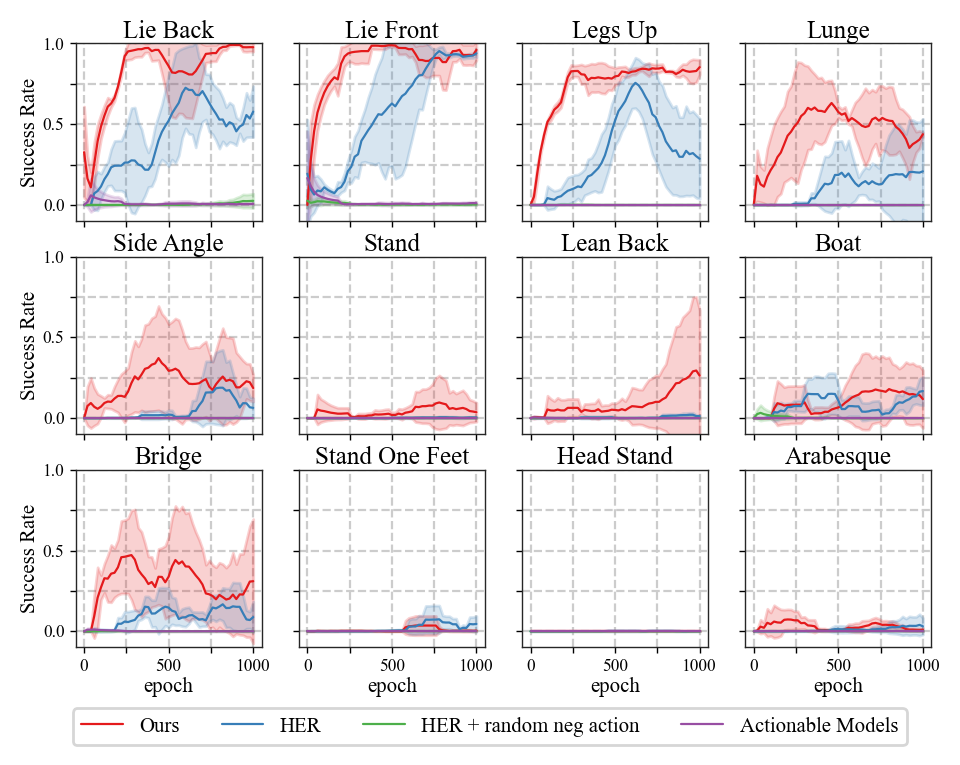

In [188]:
fig, axes = plt.subplots(3, 4, figsize=(linewidth, 4))

titles = ['Lie Back', 'Lie Front', 'Legs Up', 'Lunge', 'Side Angle', 'Stand',
          'Lean Back', 'Boat', 'Bridge', 'Stand One Feet', 'Head Stand', 'Arabesque']

for i in range(3):
    for j in range(4):
        goal_idx = i*4 + j
        xlabel = 'epoch' if i == 2 else None
        ylabel = 'Success Rate' if j == 0 else None
        sns.lineplot(
            x="step", y=f"eval/oracle_success-goal{goal_idx}", ci="sd", data=df,
            hue="exp_id", legend=False, palette='Set1', linewidth=.8,
            ax=axes[i, j], label='prout'
        ).set(title=titles[goal_idx], xlabel=xlabel, ylabel=ylabel, ylim=(-0.1, 1))
        axes[i, j].set_xticks([0, 250, 500, 750, 1000], labels=[0, None, 500, None, 1000])
        axes[i, j].set_yticks([0, 0.25, 0.5, 0.75, 1.0], [0., None, 0.5, None, 1.0])
        if j > 0:
            axes[i, j].tick_params(labelleft=False)
        if i < 2:
            axes[i, j].tick_params(labelbottom=False)

lines, labels = axes[-1, -1].get_legend_handles_labels()
labels = list(exp_dict.keys())
fig.legend(lines, labels, ncol = 4, loc="lower center",  bbox_to_anchor = (0,-0.01,1,1), bbox_transform = plt.gcf().transFigure)
plt.show()

fig.savefig(os.path.join(save_dir, "walker_by_goal.pdf"), bbox_inches='tight')
